# Описание проекта


**Задача**

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.

Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас.

Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Ваша задача — провести анализ и подготовить план действий по удержанию клиентов.

А именно:
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
  - выделить целевые группы клиентов;
  - предложить меры по снижению оттока;
  - определить другие особенности взаимодействия с клиентами.


# Описание данных

Данные клиента за предыдущий до проверки факта оттока месяц:

- `gender` — пол;
- `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
- `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- `Phone` — наличие контактного телефона;
- `Age` — возраст;
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).


Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:

- `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
- `Group_visits` — факт посещения групповых занятий;
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- `Churn` — факт оттока в текущем месяце.

## Загрузка данных, импорт библиотек, предобработка


In [1]:
import pandas as pd

import numpy as np

import seaborn as sns

import plotly.express as px

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
data = pd.read_csv('/datasets/gym_churn.csv')

pd.options.display.float_format = '{:,.2f}'.format # задаем отображение для вещественных чисел

In [3]:
data.info()

data.sample(n=3, random_state=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
200,0,1,1,0,1,1,0,34,46.49,1.00,0,1.01,0.00,1
1078,1,1,0,0,1,1,0,27,24.55,1.00,4,1.39,0.98,1
610,1,1,1,1,1,6,1,31,85.67,6.00,1,1.01,0.73,1


In [4]:
# приведем названия столбцов к нижнему регистру

data.columns = data.columns.str.lower()

In [5]:
# проверим на дубликаты

data.duplicated().sum()

0

In [6]:
# приведем данные о сроке до окончания текущего действующего абонемента в целочисленный тип

data['month_to_end_contract'] = data['month_to_end_contract'].astype('int')

In [7]:
data.sample()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
949,0,1,1,1,1,12,0,30,158.41,11,1,1.47,1.54,0


Данные готовы для дальнейшего анализа, дубликатов и пропусков не обнаружено, названия столбцов приведены для удобства к нижнему регистру и нужному формату

## Исследовательский анализ данных 

### Отсутствующие признаки,  средние значения и стандартные отклонения

In [8]:
data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,"4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00"
mean,0.51,0.85,0.49,0.31,0.90,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.30,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.00,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.00,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.00,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.00,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


Судя по среднему и стандартному отклонению, в "Культуристе" достигнут гендерный баланс - мужчин и женщин практически поровну. По возрасту также состав клиентов довольно однородный - можно сказать, что это "клуб 30-летних". Большинство проживают в районе, где расположен фитнес-центр, примерно половина - сотрудники компаний-партнеров. Краткосрочные абонементы на месяц и абонементы на полгода более востребованы, чем покупка годового. Основная часть клиентов пришли недавно, в течении последних нескольких месяцев, преданных поклонников меньшинство, как и фанатов фитнеса - преимущественно люди посещают зал 2, максимум 3 раза в неделю. Доли оттока говорят о том, что примерно 1/4 клиентов отваливаются.

Есть отсутствующие признаки - нули в числовых колонках `lifetime`, `avg_class_frequency_total`, `avg_class_frequency_current_month` - видимо, это новые клиенты текущего месяца, которые еще не успели воспользоваться своим абонементом.

### Средние значения признаков в разбивке по группам

In [9]:
# сгруппируем ушедших и оставшихся по признакам
data.groupby('churn').agg('mean').T

churn,0,1
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
contract_period,5.75,1.73
group_visits,0.46,0.27
age,29.98,26.99
avg_additional_charges_total,158.45,115.08
month_to_end_contract,5.28,1.66


В целом выглядит ожидаемо - реже отваливаются те клиенты, которые живут в том же районе, пришли по партнерской программе или по акции от друга. Абонеметы у них более долгосрочные, а посещаемость стабильная, денег в клубе они оставляют больше за счет дополнительных услуг. В отток чаще уходят новички и с низкой мотивацией или не имеющие достаточного свободного времени - это видно по более редким и снижающимся посещениям. Пол никак не влияет, а вот с возрастом есть различия - клиенты около 30 реже уходят, чем те, кто чуть моложе.

### Распределения признаков для тех, кто ушёл и тех, кто остался 

In [10]:
leave = data.query('churn == 1') # те, кто попал в отток

stay = data.query('churn == 0') # клиенты, не попавшие в отток

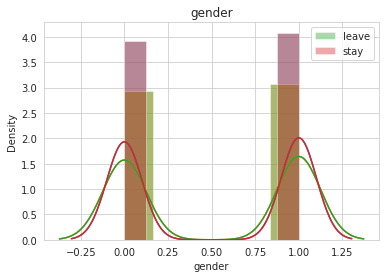

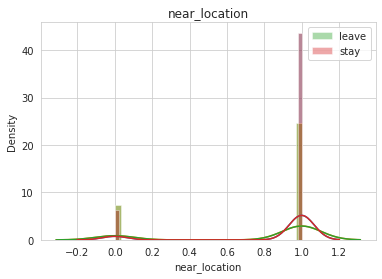

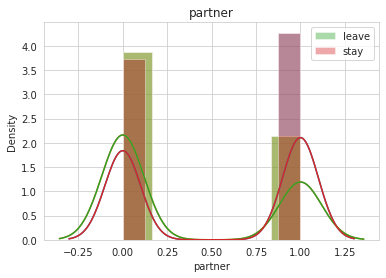

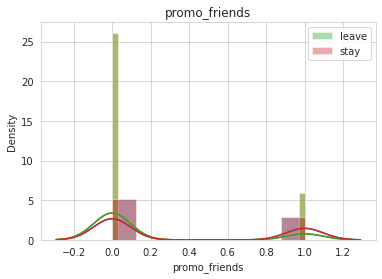

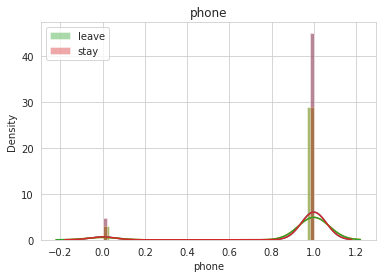

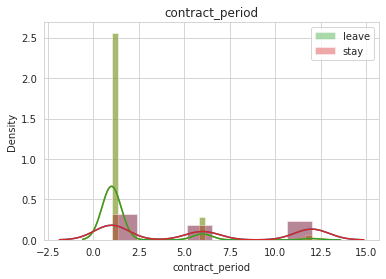

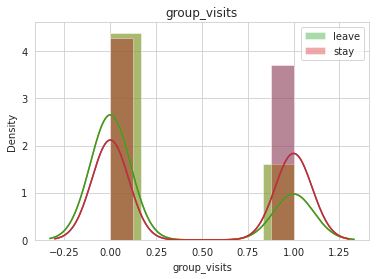

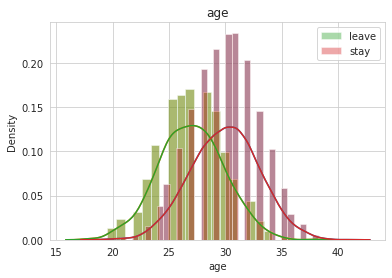

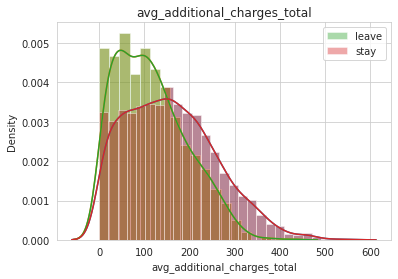

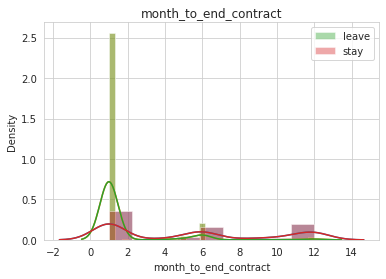

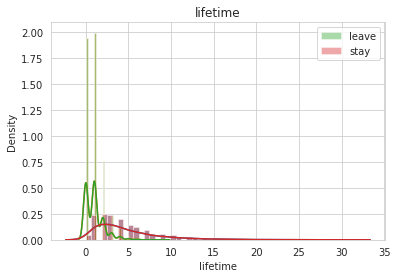

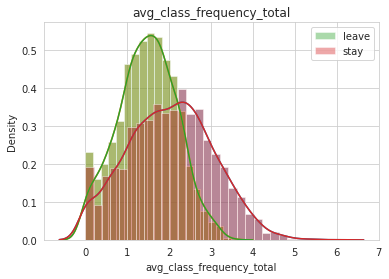

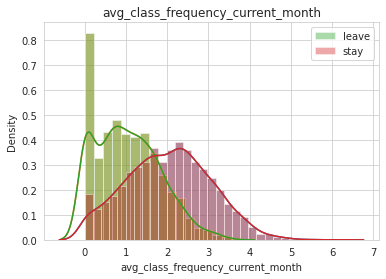

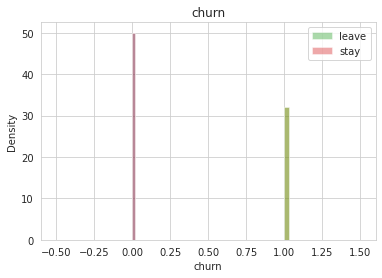

In [11]:
sns.set_style("whitegrid")
for column in data.columns:
    sns.distplot(stay[column], axlabel=False)
    ax = sns.distplot(leave[column], axlabel=False)
    plt.title(column)
    sns.distplot(leave[column], label='leave')
    sns.distplot(stay[column], label='stay')
    plt.legend()
    plt.show()

Графики подтверждают выводы выше:

- Среди сотрудников компаний-партнёров клуба в два раза больше оставшихся, чем ушедших
- Те, кто пришел по акции "приведи друга" отваливаются примерно раз в 5 реже
- Новички, оформившие абонемент на один месяц с высокой долей вероятности перестанут ходить сразу же
- Посещающие групповые программы отваливаются в среднем в два раза реже
- Графики распеделения по возрасту и полу выглядят как нормальные - закономерностей нет
- Графики посещений подтверждают, те кто в оттоке занимались реже, раз-полтора в неделю, оставшиеся посещают чаще - 2-2,5 раза в неделю


### Матрица корреляции

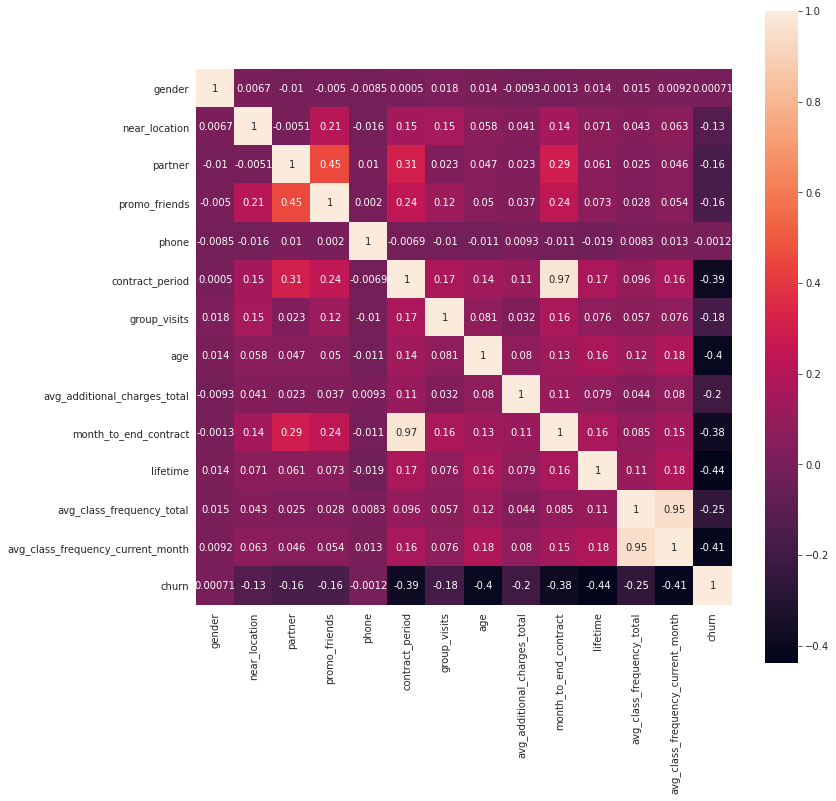

In [12]:
corr_m = data.corr() 

plt.figure(figsize=(12, 12))
sns.heatmap(data = corr_m, square = True, annot = True) 
plt.show()

Нет признаков, сильно коррелирующих с целевой переменной и следовательно оказывающих на нее сильное влияние. Пол клиента и оставил ли он свой номер телефона, никак не соотносятся с фактом оттока. Факторы, сильнее других влияющие на то, останется клиент или уйдет: длительность абонемента, возраст, лайфтайм и период до окончания действующего абонемента, а также частота посещений в предыдущем месяце.

Есть пара скоррелированных между собой признаков - `month_to_end_contract и contract_period`, а также `avg_class_frequency_total` и `avg_class_frequency_current_month`. Избавимся от одного мультиколлинеарного признака в каждой паре перед построением моделей прогнозирования. 

## Построение модели прогнозирования оттока клиентов

In [13]:
# разделяем данные на признаки (матрица X) и целевую переменную (y)
X = data.drop('churn', axis = 1)
y = data['churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Метод случайного леса


In [14]:
scaler = StandardScaler() # обучаем StandartScaler на обучающей выборке
scaler.fit(X_train) 

X_train_st = scaler.transform(X_train) # преобразуем обучающий и валидационные наборы данных
X_test_st = scaler.transform(X_test)


rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) # задаем алгоритм

rf_model.fit(X_train_st, y_train) # обучим модель случайного леса


rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1] # делаем прогнозы

print('Accuracy : {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))


Accuracy : 0.92
Precision: 0.84
Recall: 0.81


### Логистическая регрессия

In [15]:
# удалим мультиколлинеарные признаки в каждой паре

data.drop(columns=['month_to_end_contract', 
                   'avg_class_frequency_current_month'], inplace = True) 

In [16]:
model = LogisticRegression() # задаем алгоритм 

model.fit(X_train, y_train) # обучаем модель

predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:, 1] # делаем прогнозы

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))

Accuracy: 0.91
Precision: 0.82
Recall: 0.80


Обе модели демонстрируют хорошую способность прогронозирования. Однако метрики модели случайного леса выглядят получше: доля правильных ответов, точность и полнота - все показатели выше.


## Кластеризация пользователей

In [17]:
data_cl = data.drop(['churn'], axis=1) # исключаем целевой признак оттока

In [18]:
sc = StandardScaler()
x_sc = sc.fit_transform(data_cl) # стандартизируем данные

### Построение дендограммы

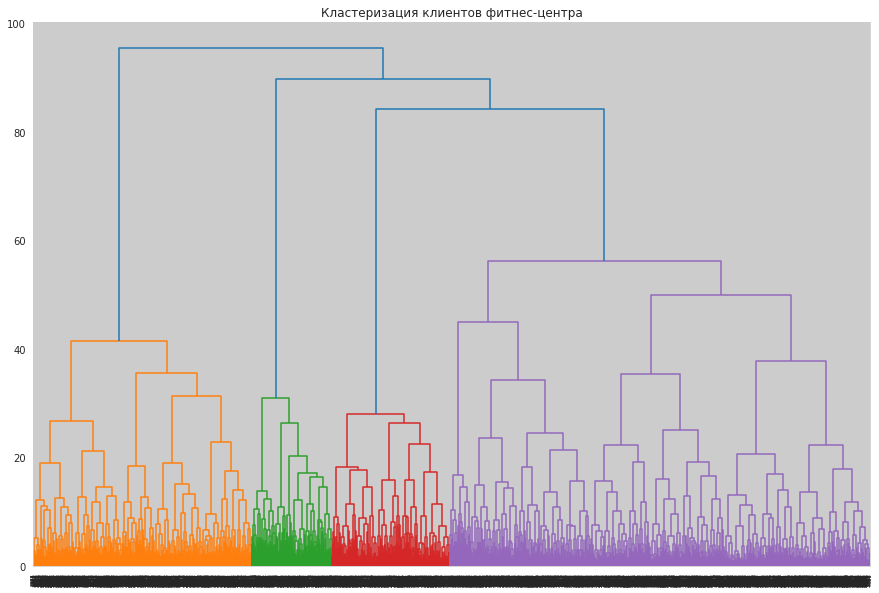

In [19]:
linked = linkage(x_sc, method = 'ward') 

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация клиентов фитнес-центра')
plt.show()

Ориентируясь на количество цветов на графике, можно выделить 4 кластера, но так как по условию задания просят спрогнозировать 5, остановимся на этом числе

### Кластеризация  К-Means

In [20]:
km = KMeans(n_clusters=5, random_state=0) # задаём модель k_means и число кластеров

labels = km.fit_predict(x_sc) # прогнозируем кластеры для наблюдений

data['cluster'] = labels # сохраняем метки кластера в датасет

### Cредние значения признаков для кластеров

In [21]:
clusters = data.groupby(['cluster']).mean().T

clusters

cluster,0,1,2,3,4
gender,0.50,0.49,0.51,0.54,0.52
near_location,0.00,1.00,1.00,1.00,0.86
partner,0.49,0.96,0.24,0.25,0.47
promo_friends,0.08,0.89,0.06,0.08,0.31
phone,1.00,1.00,1.00,1.00,0.00
contract_period,3.03,7.66,2.82,4.53,4.78
group_visits,0.24,0.46,0.00,1.00,0.43
age,28.72,29.54,28.77,29.54,29.30
avg_additional_charges_total,137.54,155.86,143.38,148.09,144.21
lifetime,3.06,4.38,3.34,3.76,3.94


Нулевой и второй кластеры склонны к оттоку сильнее остальных, из них ушло больше трети в каждом. Клиенты из нулевого живут в другом районе. Первый кластер выделяется более длительными абонементами по сравнению с другими, у нулевого и второго - в среднем более краткострочные. Посетители из "надежного" первого кластера в среднем тратят больше на дополнительные услуги в фитнес-центре, их "срок жизни" больше, и посещаемость в неделю незначительно, но стабильнее, в основном они пришли по партнерской программе или акции


### Распределения признаков для кластеров

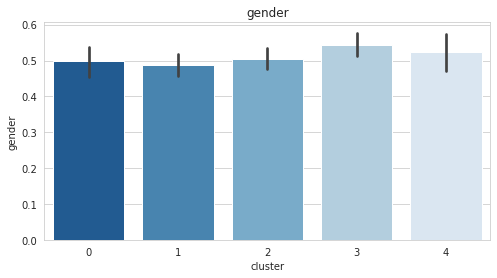

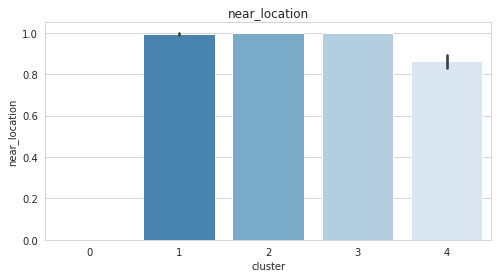

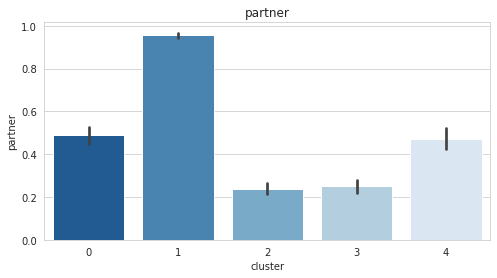

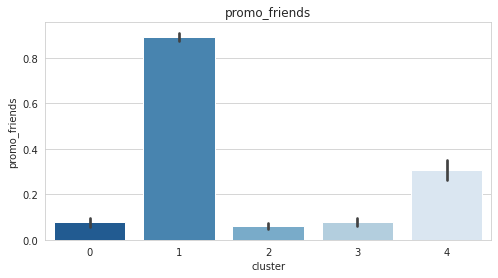

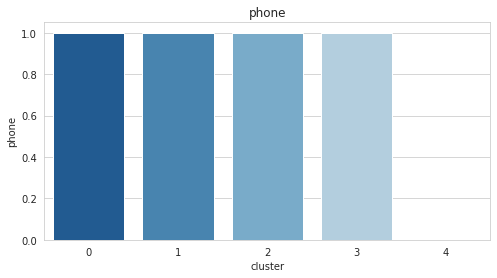

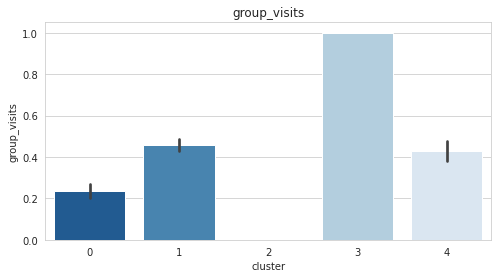

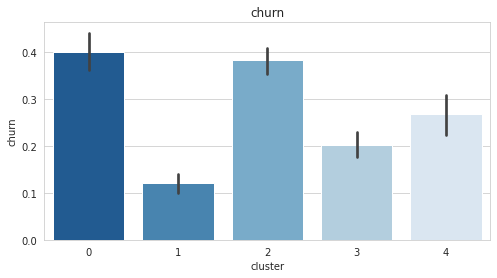

In [22]:
# для бинарных признаков

for column in ['gender',
               'near_location',
               'partner', 
               'promo_friends', 
               'phone', 
               'group_visits', 
               'churn']:
    plt.figure(figsize=(8, 4))
    sns.barplot(x='cluster', y=data[column], data=data, palette='Blues_r')
    plt.title(column)
    plt.show()

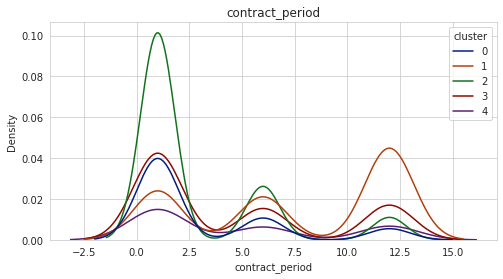

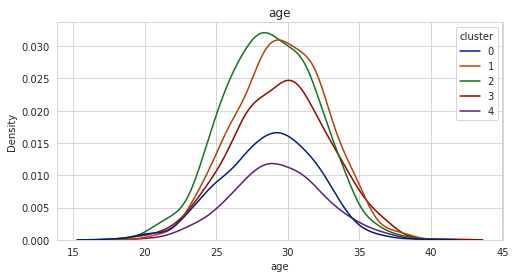

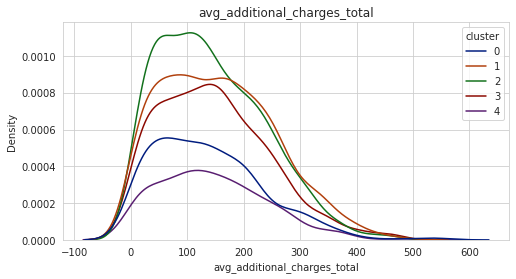

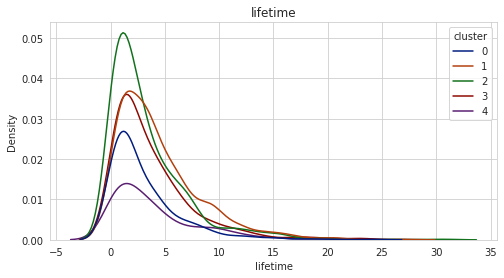

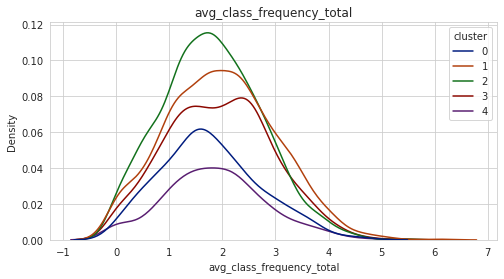

In [23]:
# для числовых признаков

for column in ['contract_period', 
               'age', 
               'avg_additional_charges_total', 
               'lifetime', 
               'avg_class_frequency_total']:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=data, x=column, hue='cluster', palette='dark')
    plt.title(column)
    plt.show()

Наблюдения по графикам распределения признаков по кластерам подтверждают выводы выше. По возрасту и гендеру группы достаточно однородные, нет явных отличий. В первом кластере большинство клиентов пришли по партнерской программе и акции, абонементы у них самые длительные. Второй напротив, отличается краткосрочностью абонементов. В третьем чаще остальных ходят на групповые занятия. Похоже, что во втором кластере много новичков (короткий лайфтайм), которые в начале тратили больше денег на дополнительные услуги, но быстро сдулись. В первом кластере тратят стабильнее.

### Доля оттока по кластерам

In [24]:
# группируем кластеры по факту оттока
users = data.groupby(['cluster', 'churn'])['cluster'].count().reset_index(level=1).rename(
    columns={'cluster': 'count'})

# добавляем колонку с % оттока в каждом кластере
users['%'] = data.query('churn == 1').groupby('cluster').agg(
    {'gender': 'count'}) / data.groupby('cluster').agg({'gender': 'count'}) * 100

users

,churn,count,%
cluster,,,
0,0,337,39.93
0,1,224,39.93
1,0,923,12.10
1,1,127,12.10
2,0,700,38.16
2,1,432,38.16
3,0,696,20.09
3,1,175,20.09
4,0,283,26.68


Меньше всего отток из первого кластера, всего 12%, на втором месте по доле оттока третий - там он составил 20%. Больше всего ушло из нулевого и второго кластеров - 39% и 38% соответственно. Из четвертого отвалилось 26% клиентов.

## Выводы и  базовые рекомендации по работе с клиентами


**Основные выводы:**

Клиент с высокой долей вероятности уйдет в следующей месяце, если его средняя частота посещений в неделю в текущем месяце снизилась по сравнению с предыдущими месяцами.

Признаки, наиболее сильно влияющие на отток: 
- территориальное расположение (клиент живет в другом районе)
- клиент пришел не в рамках акции или программы-партнера, т.е. не получил получил никаких спецпредложений
- приобретение краткосрочного абонемента взамен более длительного
- нестабильное посещение, реже 2х раз в неделю в среднем


Признаки надежных групп клиентов, не склонных к оттоку:
- продолжительный лайфтайм: клиент с клубом дольше нескольких месяцев
- длительный абонемент - на 6 месяцев или год 
- стабильное посещение не реже 2х раз в неделю
- расходы на дополнительные услуги выше среднего
- возраст ближе к среднему возрасту посетителей - 30 лет

**Рекомендации по работе с клиентами**

- Таргет на привлечение новых клиентов в первую очередь из района, где расположен клуб
- Акции для новых посетителей с короткими абонементами - новичкам часто не хватает первоначальной мотивации для продолжения занятий и времени для формирования привычки. Например скидка на первые персональные тренировки и т.д.
- Отслеживание частоты посещения - при снижении немедленно реагировать предложениями, чтобы клиент не попал в отток
- Поддержка групповых программ, выявление самых популярных, возможное расширение сетки - групповые сбособствуют удержанию клиентов
- Внимание к тем, кто давно с клубом и занимается регулярно, то есть клиентам из надежных кластеров - они приносят больше всего дохода

**Рекомендации по составлению базы**

- указывать в документации, чему соответствует 0 и 1 в классификации пола, в данном случае отличий по гендерным признакам не наблюдается, но в другой раз это может оказаться важным

- включать в датасет уникальный номер клиента, иначе неясно как менеджерам в дальнейшем определять, находится ли конкретный человек в надежном кластере или том, что склонен к оттоку